# Part 1: 
In your project you have been working with a bias dataset. Most probabely suupervised models were underfit. You should remember that this is a real dataset, and in real life most of the time you dont have access to clean and unbias dataset. In situations like this, none of the regression models will have a good fit for the dataset due to the large predence of the 0s. In the first part of this take-home exam, you are asked to be creative, and find a solution for this problem. 

For this dataset, you can break the problem, into a two-step machine learning model. 

First step is to classify the data points as positive revenue and zero revenue. This simply is a binary classification. You should remember that when you are dealing with biased datasets, accuracy is not a reliable scoring metric. So look for a robust scoring function. 

Next, you need to build a regression model to postprocess classification results. Here is a flow chart to show you the outline of the model. 

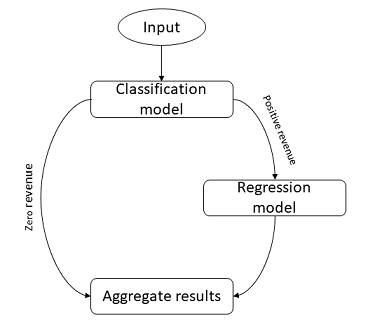

### Import Libraries

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from pandas.io.json import json_normalize
import json
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

### Read data into Jupyter Notebook

In [212]:
data = pd.read_csv('data.csv')

### Pre-processing and Data exploration

1. Check for missing data

For each column the number of null values is counted. From the result below, it is clear that the columns 'totals_bounces', 'totals_newVisits', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_totalTransactionRevenue', 'totals_transactionRevenue' and 'totals_transactions' have a lot of missing values.

In [3]:
data.isna().sum()

channelGrouping                       0
customDimensions                      0
date                                  0
device                                0
fullVisitorId                         0
geoNetwork                            0
hits                                  0
socialEngagementType                  0
trafficSource                         0
visitId                               0
visitNumber                           0
visitStartTime                        0
totals_bounces                    10127
totals_hits                           0
totals_newVisits                   4912
totals_pageviews                      1
totals_sessionQualityDim          10880
totals_timeOnSite                  9899
totals_totalTransactionRevenue    19807
totals_transactionRevenue         19807
totals_transactions               19804
totals_visits                         0
dtype: int64

2. Understand data types in the dataset

Let us examine the different types of data that are present.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
channelGrouping                   20000 non-null object
customDimensions                  20000 non-null object
date                              20000 non-null int64
device                            20000 non-null object
fullVisitorId                     20000 non-null uint64
geoNetwork                        20000 non-null object
hits                              20000 non-null object
socialEngagementType              20000 non-null object
trafficSource                     20000 non-null object
visitId                           20000 non-null int64
visitNumber                       20000 non-null int64
visitStartTime                    20000 non-null int64
totals_bounces                    9873 non-null float64
totals_hits                       20000 non-null int64
totals_newVisits                  15088 non-null float64
totals_pageviews                  19999 non-null float6

3. Flatten JSON data

It can be seen that the values in five columns: 'customDimensions', 'device', 'geoNetwork', 'hits' and 'trafficSource' appear as JSON. Hence, the values in these columns need to be flattened so that necessary information can be extracted.

- Flatten data in 'customDimensions' column

In [213]:
data['customDimensions']=data['customDimensions'].apply(literal_eval)
data['customDimensions']=data['customDimensions'].str[0]
data['customDimensions']=data['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
custDim_df = pd.io.json.json_normalize(data['customDimensions'])

- Flatten data in 'device' column

In [214]:
device_df = pd.io.json.json_normalize(data['device'].apply(eval))

- Flatten data in 'geoNetwork' column

In [215]:
geoNetwork_df = pd.io.json.json_normalize(data['geoNetwork'].apply(eval))

- Flatten data in 'hits' column

In [216]:
data['hits']=data['hits'].apply(literal_eval)
data['hits']=data['hits'].str[0]
data['hits']=data['hits'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
hits_df = pd.io.json.json_normalize(data['hits'])

- Flatten data in 'trafficSource' column

In [217]:
trafficSource_df = pd.io.json.json_normalize(data['trafficSource'].apply(eval))

4. Drop columns not required from flattened data

- Extract required data from 'customDimensions'

In [10]:
custDim_df.head()

,index,value
0,4,EMEA
1,4,North America
2,4,North America
3,4,EMEA
4,4,Central America


We do not need the 'index' column as it is just a constant number. The 'value' column represents an aggregated business region.

In [218]:
d1 = custDim_df[['value']]

- Extract required data from 'device' column

In [12]:
device_df.head(3)

,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution
0,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset
2,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset


I can see that: browserSize, browserVersion, flashVersion, language, mobileDeviceBranding, mobileDeviceInfo, mobileDeviceMarketingName, mobileDeviceModel, mobileInputSelector, operatingSystemVersion, screenColors and screenResolution are 'not available in demo dataset'.

Hence I will drop these columns and keep just deviceCategory, isMobile and OperatingSystem.

In [219]:
d2 = device_df[['deviceCategory','isMobile','operatingSystem']]

- Extract required data from 'geoNetwork' column

In [14]:
geoNetwork_df.head(3)

,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent
0,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe
1,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America
2,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,Northern America


I can see that city, cityId, latitude, longitude, metro, networkLocation and region are not available in demo dataset. I can drop these columns as they are of no use.

Hence, I will retain only columns continent and country. However this is an overlap with the Value column from customDimensions as it also represents aggregated geographic business regions.

In [220]:
d3 = geoNetwork_df[['continent','country']] 
geoNetwork_df['continent'].value_counts()

Americas     10521
Europe        4511
Asia          4253
Africa         357
Oceania        337
(not set)       21
Name: continent, dtype: int64

However, I can see that 21 records do not have a continent correctly labelled. Hence, I will stick to the value column from customDimensions to represent geographic aggregation.

- Extract required data from 'hits' column

In [16]:
hits_df.head(3)

,appInfo.exitScreenName,appInfo.landingScreenName,appInfo.screenDepth,appInfo.screenName,contentGroup.contentGroup1,contentGroup.contentGroup2,contentGroup.contentGroup3,contentGroup.contentGroup4,contentGroup.contentGroup5,contentGroup.contentGroupUniqueViews1,...,promotionActionInfo.promoIsView,publisher_infos,referer,social.hasSocialSourceReferral,social.socialInteractionNetworkAction,social.socialNetwork,time,transaction.currencyCode,type,value
0,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,shop.googlemerchandisestore.com/google+redesig...,(not set),Bags,(not set),(not set),(not set),NaN,...,NaN,[],https://www.google.co.uk/search?q=water+bottle...,No,:,(not set),0,USD,PAGE,NaN
1,shop.googlemerchandisestore.com/asearch.html,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,True,[],https://sites.google.com/a/google.com/transpor...,No,:,(not set),0,NaN,PAGE,NaN
2,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,True,[],https://www.googlemerchandisestore.com/,No,:,(not set),0,NaN,PAGE,NaN


Hits has mainly text based information. Not optimal to make classes or digits for regression. Hence I am dropping the column completely.

- Extract required data from 'trafficSource' column

In [17]:
trafficSource_df.head(3)

,adContent,adwordsClickInfo.adNetworkType,adwordsClickInfo.criteriaParameters,adwordsClickInfo.gclId,adwordsClickInfo.isVideoAd,adwordsClickInfo.page,adwordsClickInfo.slot,campaign,isTrueDirect,keyword,medium,referralPath,source
0,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)


I can see that adContent, adwordsClickInfo.adNetworkType, adwordsClickInfo.criteriaParameters, adwordsClickInfo.gclId, adwordsClickInfo.isVideoAd, adwordsClickInfo.page, adwordsClickInfo.slot have a lot of NaN or Not available in demo dataset.

I will retain the column medium.

In [221]:
d4 = trafficSource_df[['medium']]

4. Create a backup copy of the original dataset and drop the json columns

In [222]:
data_copy = data
data = data.drop(['hits','customDimensions','device','trafficSource', 'geoNetwork'], axis = 1)

5. Merge extracted features into the dataset

In [223]:
data = data.join(d1)
data = data.join(d2)
data = data.join(d4)
data.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,...,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,value,deviceCategory,isMobile,operatingSystem,medium
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,...,NaN,NaN,NaN,NaN,1,EMEA,desktop,False,Windows,organic
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,NaN,2,NaN,...,28.0,NaN,NaN,NaN,1,North America,desktop,False,Chrome OS,referral
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,NaN,2,1.0,...,38.0,NaN,NaN,NaN,1,North America,mobile,True,Android,(none)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,NaN,2,1.0,...,1.0,NaN,NaN,NaN,1,EMEA,desktop,False,Windows,organic
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,NaN,2,1.0,...,52.0,NaN,NaN,NaN,1,Central America,desktop,False,Windows,organic


For regression I need categorical or numeric input variables. For clustering I need only numeric data. So I will drop a few more columns: date, fullVisitorId, socialEngagementType, visitId, visitStartTime as they are neither categorical nor numeric.

I will also drop the medium column as it essentially is the same as channelGrouping. If I use both the columns, it will lead to the problem of multicollinearity.

In [224]:
data_copy2 = data
data = data.drop(['date','fullVisitorId','socialEngagementType','visitId', 'visitStartTime', 'medium' ], axis = 1)

6. Replace all NaNs with 0

In [225]:
data.fillna(value = 0, inplace = True)
data.head()

,channelGrouping,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,value,deviceCategory,isMobile,operatingSystem
0,Organic Search,1,1.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,EMEA,desktop,False,Windows
1,Referral,6,0.0,2,0.0,2.0,2.0,28.0,0.0,0.0,0.0,1,North America,desktop,False,Chrome OS
2,Direct,1,0.0,2,1.0,2.0,1.0,38.0,0.0,0.0,0.0,1,North America,mobile,True,Android
3,Organic Search,1,0.0,2,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1,EMEA,desktop,False,Windows
4,Organic Search,1,0.0,2,1.0,2.0,1.0,52.0,0.0,0.0,0.0,1,Central America,desktop,False,Windows


7. Exploratory Visualizations

In [23]:
%matplotlib inline

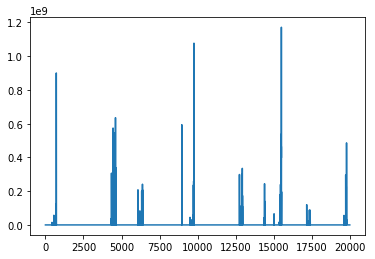

In [24]:
data['totals_transactionRevenue'].plot()

It can be seen above that for most customers the total transaction revenue is zero. Hence, the data is skewed / imbalanced.

Text(0.5,1,'Time Spent on Google Merchandise Store by Device')

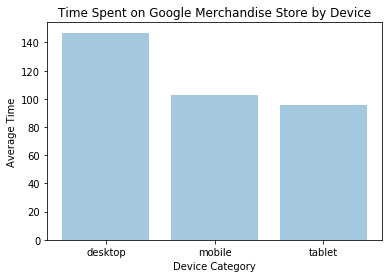

In [25]:
g = data.groupby('deviceCategory').mean()['totals_timeOnSite']
plt.bar(data['deviceCategory'].unique(),g,alpha = 0.4)
plt.xlabel('Device Category')
plt.ylabel('Average Time')
plt.title('Time Spent on Google Merchandise Store by Device')

Hence, it can be seen that users who use a Desktop on average spend much more time on the website than those who use mobiles and tablets.

8. Data Scaling

All numerical features of the dataset need to be scaled so that all features have the same weight when computing Euclidian distances.

In [226]:
data_forscaling = data[['visitNumber','totals_bounces','totals_hits','totals_newVisits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite','totals_totalTransactionRevenue','totals_transactionRevenue']]

I prefer the MinMaxScaler as all values for a feature are restricted to values between 0 and 1. This sort of a result is very easy to interpret.

In [227]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler()
data_scaled = sc.fit_transform(data_forscaling)

C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [228]:
data_scaleddf = pd.DataFrame(data_scaled)
data_scaleddf.head(3)

,0,1,2,3,4,5,6,7,8
0,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0
1,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0
2,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0


In [229]:
data_scaleddf.columns =['visitNumber','totals_bounces','totals_hits','totals_newVisits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite','totals_totalTransactionRevenue','totals_transactionRevenue']
data_scaleddf.head(3)

,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue
0,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0
1,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0
2,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0


### Supervised Learning - Linear Regression

In [230]:
data_LReg = data.drop(['visitNumber','totals_bounces','totals_hits','totals_newVisits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite','totals_totalTransactionRevenue','totals_transactionRevenue','totals_visits'], axis =1)
data_LReg = data_LReg.join(data_scaleddf)
data_LReg.head(3)

,channelGrouping,totals_transactions,value,deviceCategory,isMobile,operatingSystem,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue
0,Organic Search,0.0,EMEA,desktop,False,Windows,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0
1,Referral,0.0,North America,desktop,False,Chrome OS,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0
2,Direct,0.0,North America,mobile,True,Android,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0


Create dummy variables for categorical features

In [231]:
dv1 = pd.get_dummies(data_LReg['channelGrouping'])
dv2 = pd.get_dummies(data_LReg['value'])
dv3 = pd.get_dummies(data_LReg['deviceCategory'])
#dv4 = pd.get_dummies(data_LReg['isMobile'])
#dv5 = pd.get_dummies(data_LReg['operatingSystem'])

For each of the dummy variables we need to set a baseline reference. I will consider the first dummy column of each variable as the baseline reference.

In [232]:
dv1 = dv1.iloc[:,1:]
dv2 = dv2.iloc[:,1:]
dv3 = dv3.iloc[:,1:]
#dv4 = dv4.iloc[:,1:]
#dv5 = dv5.iloc[:,1:]

Drop the categorical features from the main dataset and replace with binary encoded dummy variables

In [233]:
data_LReg = data_LReg.drop(['channelGrouping', 'value', 'deviceCategory', 'isMobile', 'operatingSystem'], axis = 1)
data_LReg = data_LReg.join(dv1)
data_LReg = data_LReg.join(dv2)
data_LReg = data_LReg.join(dv3)
#data_LReg = data_LReg.join(dv4)
#data_LReg = data_LReg.join(dv5)

In [167]:
data_LReg.head(3)

,totals_transactions,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,...,Paid Search,Referral,Social,APAC,Central America,EMEA,North America,South America,mobile,tablet
0,0.0,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
2,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


### Classifier

Convert the target label values to 0s and 1s

In [234]:
data_LReg['RevenueCat'] = data_LReg['totals_transactions'].apply(lambda x: 1 if x>0 else 0)
data_LReg.head(3)

,totals_transactions,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,...,Referral,Social,APAC,Central America,EMEA,North America,South America,mobile,tablet,RevenueCat
0,0.0,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
2,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0


Create a new df where you remove total_transactions(because u created masked column) and RevenueCat because you will predict it

In [235]:
df_classifier = data_LReg.drop(['totals_transactions','totals_totalTransactionRevenue','totals_transactionRevenue'],axis =1)

Extract features & target variable

In [236]:
X = df_classifier.drop(['RevenueCat'],axis =1)
y = df_classifier['RevenueCat']

Split data into training and test sets

In [237]:
X_train_GNB, X_test_GNB, y_train_GNB, y_test_GNB = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [191]:
X.columns

Index(['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits',
       'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite',
       'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral',
       'Social', 'APAC', 'Central America', 'EMEA', 'North America',
       'South America', 'mobile', 'tablet'],
      dtype='object')

Call an instance of the model and fit on training data

In [238]:
from sklearn.naive_bayes import GaussianNB

modelgnb = DecisionTreeClassifier()     
modelgnb.fit(X_train_GNB, y_train_GNB)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Use the model to predict values for test data

In [239]:
y_modelgnb = modelgnb.predict(X_test_GNB)

In [240]:
(pd.DataFrame(y_modelgnb)[0]).value_counts()

0    3956
1      44
Name: 0, dtype: int64

Performance metrics of Gaussian NB model

In [241]:
from sklearn.metrics import accuracy_score
accuracy_score(y_modelgnb, y_test_GNB)

0.9825

In [242]:
data_LReg['PredictedValue'] = modelgnb.predict(X)

In [243]:
data_LReg['PredictedValue'].value_counts()

0    19802
1      198
Name: PredictedValue, dtype: int64

In [199]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_classifier[df_classifier.RevenueCat==0]
df_minority = df_classifier[df_classifier.RevenueCat==1]

In [210]:
df_minority.count()

visitNumber                 196
totals_bounces              196
totals_hits                 196
totals_newVisits            196
totals_pageviews            196
totals_sessionQualityDim    196
totals_timeOnSite           196
Direct                      196
Display                     196
Organic Search              196
Paid Search                 196
Referral                    196
Social                      196
APAC                        196
Central America             196
EMEA                        196
North America               196
South America               196
mobile                      196
tablet                      196
RevenueCat                  196
dtype: int64

In [200]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=196,     # to match minority class
                                 random_state=123)

In [201]:
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [202]:
# Display new class counts
df_downsampled.RevenueCat.value_counts()

1    196
0    196
Name: RevenueCat, dtype: int64

In [203]:
# Separate input features (X) and target variable (y)
y1 = df_downsampled.RevenueCat
X1 = df_downsampled.drop('RevenueCat', axis=1)

In [204]:
X1_train_GNB, X1_test_GNB, y1_train_GNB, y1_test_GNB = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [205]:
modelgnb2 = GaussianNB()     
modelgnb2.fit(X1_train_GNB, y1_train_GNB)

GaussianNB(priors=None, var_smoothing=1e-09)

In [207]:
df_downsampled['PredictedValue2'] = modelgnb2.predict(X1)

In [208]:
accuracy_score(df_downsampled['PredictedValue2'], df_downsampled['RevenueCat'])

0.8086734693877551

In [209]:
data_LReg['PredictedValue3'] = modelgnb2.predict(X)
data_LReg['PredictedValue3'].value_counts()

0    13522
1     6478
Name: PredictedValue3, dtype: int64

In [178]:
data_LReg.head(3)

,totals_transactions,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,...,Social,APAC,Central America,EMEA,North America,South America,mobile,tablet,RevenueCat,PredictedValue
0,0.0,0.0000,1.0,0.000000,1.0,0.006061,0.010417,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1


In [179]:
dataReg = data_LReg[data_LReg['PredictedValue'] == 1]
dataReg.head(3)

,totals_transactions,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,...,Social,APAC,Central America,EMEA,North America,South America,mobile,tablet,RevenueCat,PredictedValue
1,0.0,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
5,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.020833,0.002161,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1


In [180]:
dataReg.shape

(6483, 25)

In [181]:
dataReg = dataReg.drop(['RevenueCat'], axis =1)
dataReg.head(3)

,totals_transactions,visitNumber,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,...,Referral,Social,APAC,Central America,EMEA,North America,South America,mobile,tablet,PredictedValue
1,0.0,0.0125,0.0,0.004386,0.0,0.012121,0.020833,0.005042,0.0,0.0,...,1,0,0,0,0,1,0,0,0,1
2,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.010417,0.006843,0.0,0.0,...,0,0,0,0,0,1,0,1,0,1
5,0.0,0.0000,0.0,0.004386,1.0,0.012121,0.020833,0.002161,0.0,0.0,...,1,0,0,0,0,1,0,0,0,1


In [182]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [183]:
J = dataReg.drop(['totals_totalTransactionRevenue','totals_transactionRevenue'], axis =1)
K = dataReg['totals_transactionRevenue']

In [184]:
J_train, J_test, K_train, K_test = train_test_split(J, K,test_size=0.20, random_state=0)

In [185]:
linreg = LinearRegression()
linreg.fit(J_train, K_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [186]:
K_predicted = linreg.predict(J_test)

In [187]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [188]:
mean_squared_error(K_test,K_predicted)

0.0003839288389865015

In [189]:
K_predicted.shape

(1297,)

# Part 2
In this part you will create a Python function ``plot_decision_boundary`` that will accepts a machine learning model, feature set ``X``, and target set ``y`` as input and will plot the decision boundary of the input machine learning model  on ``(X,y)``. The following is a sample run of this function: 

```Python
%matplotlib inline
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)

# Plotting decision boundary
plot_decision_boundary(X, y, clf=svm)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')```

Sample output: 
![decision_boundary.png](attachment:decision_boundary.png)

In [ ]:
def plot_decision_boundary():
    """
    FIXME: complete this function.
    """
    pass